Event Driven Simulation 

In [43]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


TO DO: SINR variiert, CoMP Scheduling Procedure

In [35]:
import simpy
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import poisson


Scheduling CoMP
---------

In [44]:
import simpy
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import poisson

SCHEDULE_T=2 #Clock des Schedulers 

#function to monitor the level of the different queues
def monitor(queue,monitor): 
    monitor.update({env.now: queue.level})
    return monitor

def calculate_prb_number(users,max_prb):
    count=0
    for i in np.arange(len(users)):
        count=count+users[i].comp
    prb_number=round(count/np.size(users)*max_prb)
    return prb_number

def get_dataframe(users):
    df=pd.DataFrame()
    tbs=np.array([])
    queue=np.array([])
    mR=np.array([])
    metric=np.array([])
    qos=np.array([])
    cp=np.array([])
    cp2=np.array([])
    cell1=np.array([])
    cell2=np.array([])
    comp=np.array([])
    mon=np.array([])
    
    
    for i in np.arange(np.size(users)):
        tbs=np.append(tbs,users[i].tbs)
        queue=np.append(queue,users[i].queue)
        mR=np.append(mR,users[i].mR)
        metric=np.append(metric,users[i].metric)
        qos=np.append(qos,users[i].qos)
        cp=np.append(cp,users[i].cp)
        cp2=np.append(cp2,users[i].cp2)
        cell1=np.append(cell1,users[i].cell1)
        cell2=np.append(cell2,users[i].cell2)
        comp=np.append(comp,users[i].comp)
        mon=np.append(mon,users[i].mon)
        
    df['tbs']=tbs
    df['queue']=queue
    df['mR']=mR
    df['metric']=metric
    df['qos']=qos
    df['cp']=cp
    df['cp2']=cp2
    df['cell1']=cell1
    df['cell2']=cell2
    df['comp']=comp
    df['mon']=mon
    
    return df

def calculate_tbs(sinr,sinr2):
    mapping=pd.read_csv('Data/sinr-tbs-mapping.csv')
    tbs=mapping.iloc[sinr].values[1]
    tbs2=mapping.iloc[sinr2].values[1]
    return tbs,tbs2

def central_scheduler(env, users, SCHEDULE_T,cluster, prb_number):
    
    x=1
    return x

#scheduler takes packets from the queues according to the capacity of each user
def scheduler(env, df, SCHEDULE_T,cluster, prb_number):
    
    counter=1 #counts the number of scheduling procedures
    alpha=-np.log10(0.01)/100
    while True: #größte Warteschlange wird auch bedient
        print(env.now)
        yield env.timeout(SCHEDULE_T) #for each ms the scheduling is active -> per TTI
        metric=np.array([]) 
        
        #for i in df.index:
        #    df.iloc[i]['mon']= monitor(df.iloc[i]['queue'],df.iloc[i]['mon'])
        df.iloc[df.index[0]]['mon']= monitor(df.iloc[df.index[0]]['queue'],df.iloc[df.index[0]]['mon'])
        df.iloc[df.index[5]]['mon']= monitor(df.iloc[df.index[5]]['queue'],df.iloc[df.index[5]]['mon'])
        df.iloc[df.index[20]]['mon']= monitor(df.iloc[df.index[20]]['queue'],df.iloc[df.index[20]]['mon'])
        
        for i in np.arange(len(df)): 
            if(df.iloc[i]['qos']==1):
                if(df.iloc[i]['queue'].level>0):
                    metric=np.append(metric, (alpha*df.iloc[i]['queue'].level*(df.iloc[i]['cp']/df.iloc[i]['mR'])))  #list the metric of all UEs in the process 
                    df.iloc[i]['mR']=(1-1/counter)*df.iloc[i]['mR'] #Ratenanpassung für alle Nutzer 
                elif(df.iloc[i]['queue'].level==0):
                    metric=np.append(metric,0)
                    df.iloc[i]['mR']=(1-1/counter)*df.iloc[i]['mR'] #Ratenanpassung für alle Nutzer
                    
            elif(df.iloc[i]['qos']==0):
                if(df.iloc[i]['queue'].level>0):
                    metric=np.append(metric,(df.iloc[i]['cp']/df.iloc[i]['mR']))
                    df.iloc[i]['mR']=(1-1/counter)*df.iloc[i]['mR'] #Ratenanpassung für alle Nutzer
                elif(df.iloc[i]['queue'].level==0):
                    metric=np.append(metric,0)
                    df.iloc[i]['mR']=(1-1/counter)*df.iloc[i]['mR'] #Ratenanpassung für alle Nutzer

        sched_user_list = (-metric).argsort() #sort UEs by metric that will be used for scheduling
        
        #print(sched_user_list)    
        #print(users[2].queue.level)
        remaining_prbs=prb_number
        
        k=0
        #print('New scheduling round')
        while(remaining_prbs>0):
            sched_user=sched_user_list[k]
            #print(sched_user)
            queue_size=df.iloc[sched_user]['queue'].level
            tbs=df.iloc[sched_user]['tbs']

            if((queue_size/tbs)<=remaining_prbs and queue_size>0):
                sched_size=queue_size
                remaining_prbs=remaining_prbs-np.ceil(queue_size/tbs)
            elif((queue_size/tbs)>remaining_prbs):
                sched_size=remaining_prbs*tbs
                remaining_prbs=remaining_prbs-sched_size
                
            elif(queue_size==0):
                print('empty queue')
                break
            else:
                print('something went wrong')
            #print('user:',sched_user)    
            #print('queue size before:',queue_size)
            #print('mR before:',users[sched_user].mR)
            df.iloc[sched_user]['mR']=df.iloc[sched_user]['mR']+(1/counter)*sched_size
            df.iloc[sched_user]['queue'].get(sched_size)
            #print('queue size after:',users[sched_user].queue.level)
            #print('mR afer:',users[sched_user].mR)
            k=k+1
        counter=counter+1
        

        
            
class ue:
    def __init__(self,sinr,sinr2,cell1,cell2,env,qos,thr):
        self.sinr=sinr
        self.sinr2=sinr2
        self.tbs,self.tbs2=calculate_tbs(sinr,sinr2)
        self.qos=qos
        self.cp=0.5*0.7*20000000*np.log2(1+np.power(10,sinr/10))/8000
        self.cp2=0.5*0.7*20000000*np.log2(1+np.power(10,sinr2/10))/8000 #division by 8000 to determine number of bits that can be transmitted per TTI (1ms)
        self.cell1=cell1
        self.cell2=cell2
        self.mR=0.1 #mittlere Rate
        self.queue=simpy.Container(env)
        self.mon={}
        self.metric=self.sinr+self.queue.level
        self.gain=self.sinr2-self.sinr
        if(self.gain >thr):
            self.comp=np.array(bool(1))
        else:
            self.comp=np.array(bool(0)) 
        
    def rt_user(self,env):
        on_off=1
        counter=0
        start=0
        while True:
            if(start==0):
                start=1
                yield env.timeout(random.randint(0,200))
            elif(on_off==1 and counter<3000):
                self.queue.put(160) #20 bytes
                mon= monitor(self.queue,self.mon)
                #yield env.timeout(poisson.rvs(6, 1))
                #print('On Phase')
                #print(self.queue.level)
                counter=counter+20
                #print(counter)
                yield env.timeout(20) #every 20ms new packet
            elif(on_off==0):
                on_off=1

                yield env.timeout(3000) #3s no packet to be sent
            elif(on_off==1 and counter>=3000):
                on_off=0
                counter=0
                #print('change from ON-OFF')
            
    def user_packets(self,env,packet_arr):
        while True:
            #print('o-user')
            self.queue.put(2000)
            #self.mon= monitor(self.queue,self.mon)
            yield env.timeout(poisson.rvs(packet_arr, 1))
            

    def streaming_user(self,env):
        while True:
            #print('o-user')
            self.queue.put(1500) #1080p-> 1.5 Mbps 
            #self.mon= monitor(self.queue,self.mon)
            yield env.timeout(2)
    
    #Noch sehr vereinfacht!!!
    def sinr_variator(self,env):
        change=round(np.random.normal(0,0.5))
        if((self.sinr+change)>-10 and (self.sinr+change)<30): 
            self.sinr=self.sinr +change
            self.sinr2=self.sinr2+change 
        yield env.timeout(2000)

##Ausführung der Simulation

env=simpy.Environment()
#env = simpy.rt.RealtimeEnvironment(factor=1/10)

ue_list=np.array([])
ue_list2=np.array([])
thr=6

#define UEs
for i in np.arange(0,100):
    ue_list=np.append(ue_list,ue(random.randint(0,20),random.randint(2,20),19,18,env,0,thr))
    ue_list2=np.append(ue_list2,ue(random.randint(0,20),random.randint(2,20),18,19,env,0,thr))
ue_list=np.append(ue_list,ue(random.randint(0,20),random.randint(2,20),19,18,env,1,thr)) 
ue_list2=np.append(ue_list2,ue(random.randint(0,20),random.randint(2,20),18,19,env,1,thr)) 
for i in np.arange(0,20):
    ue_list=np.append(ue_list,ue(random.randint(0,20),random.randint(10,20),19,18,env,1,thr))
    ue_list2=np.append(ue_list2,ue(random.randint(0,20),random.randint(10,20),18,19,env,1,thr))
    
max_prb=100
prb_number_comp=calculate_prb_number(ue_list,max_prb)
prb_number_normal=max_prb-prb_number_comp

#Dataframe structure
################################
df=get_dataframe(ue_list)
df2=get_dataframe(ue_list2)
df_comp=pd.DataFrame()

df_filter=df.groupby('comp')
df_filtered=df_filter.get_group(1)
df_comp=df_filtered
df_filter=df2.groupby('comp')
df_filtered=df_filter.get_group(1)
df_comp=df_comp.append(df_filtered,ignore_index=True)

df=df[df['comp']==0]
df2=df2[df2['comp']==0]
################################


#Start processes
env.process(scheduler(env,df,SCHEDULE_T,['19','18'],prb_number_normal))
for i in np.arange(0,100):
    env.process(ue_list[i].user_packets(env,500))
    #env.process(ue_list[i].sinr_variator()) #movement
env.process(ue_list[100].streaming_user(env))
#env.process(ue_list[100].sinr_variator()) #movement   
for i in np.arange(101,121):
    env.process(ue_list[i].rt_user(env))
    #env.process(ue_list[i].sinr_variator()) #movement


env.run(until=3000)

0
2
4


<ipython-input-44-9625a1454d9e>:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.iloc[df.index[0]]['mon']= monitor(df.iloc[df.index[0]]['queue'],df.iloc[df.index[0]]['mon'])
<ipython-input-44-9625a1454d9e>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.iloc[df.index[5]]['mon']= monitor(df.iloc[df.index[5]]['queue'],df.iloc[df.index[5]]['mon'])
<ipython-input-44-9625a1454d9e>:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d

6
8
10
12
14
16
18
20
22
24
26
28
30
32
34
36
38
40
42
44
46
48
50
52
54
56
58
60
62
64
empty queue
66
empty queue
68
empty queue
70
empty queue
72
empty queue
74
empty queue
76
empty queue
78
empty queue
80
empty queue
82
empty queue
84
empty queue
86
empty queue
88
empty queue
90
empty queue
92
empty queue
94
empty queue
96
empty queue
98
empty queue
100
empty queue
102
empty queue
104
empty queue
106
empty queue
108
empty queue
110
empty queue
112
empty queue
114
empty queue
116
empty queue
118
empty queue
120
empty queue
122
empty queue
124
empty queue
126
empty queue
128
empty queue
130
empty queue
132
empty queue
134
empty queue
136
empty queue
138
empty queue
140
empty queue
142
empty queue
144
empty queue
146
empty queue
148
empty queue
150
empty queue
152
empty queue
154
empty queue
156
empty queue
158
empty queue
160
empty queue
162
empty queue
164
empty queue
166
empty queue
168
empty queue
170
empty queue
172
empty queue
174
empty queue
176
empty queue
178
empty queue
180
e

empty queue
1150
empty queue
1152
empty queue
1154
empty queue
1156
empty queue
1158
empty queue
1160
empty queue
1162
empty queue
1164
empty queue
1166
empty queue
1168
empty queue
1170
empty queue
1172
empty queue
1174
empty queue
1176
empty queue
1178
empty queue
1180
empty queue
1182
empty queue
1184
empty queue
1186
empty queue
1188
empty queue
1190
empty queue
1192
empty queue
1194
empty queue
1196
empty queue
1198
empty queue
1200
empty queue
1202
empty queue
1204
empty queue
1206
empty queue
1208
empty queue
1210
empty queue
1212
empty queue
1214
empty queue
1216
empty queue
1218
empty queue
1220
empty queue
1222
empty queue
1224
empty queue
1226
empty queue
1228
empty queue
1230
empty queue
1232
empty queue
1234
empty queue
1236
empty queue
1238
empty queue
1240
empty queue
1242
empty queue
1244
empty queue
1246
empty queue
1248
empty queue
1250
empty queue
1252
empty queue
1254
empty queue
1256
empty queue
1258
empty queue
1260
empty queue
1262
empty queue
1264
empty queue
12

empty queue
2168
empty queue
2170
empty queue
2172
empty queue
2174
empty queue
2176
empty queue
2178
empty queue
2180
empty queue
2182
empty queue
2184
empty queue
2186
empty queue
2188
empty queue
2190
empty queue
2192
empty queue
2194
empty queue
2196
empty queue
2198
empty queue
2200
empty queue
2202
empty queue
2204
empty queue
2206
empty queue
2208
empty queue
2210
empty queue
2212
empty queue
2214
empty queue
2216
empty queue
2218
empty queue
2220
empty queue
2222
empty queue
2224
empty queue
2226
empty queue
2228
empty queue
2230
empty queue
2232
empty queue
2234
empty queue
2236
empty queue
2238
empty queue
2240
empty queue
2242
empty queue
2244
empty queue
2246
empty queue
2248
empty queue
2250
empty queue
2252
empty queue
2254
empty queue
2256
empty queue
2258
empty queue
2260
empty queue
2262
empty queue
2264
empty queue
2266
empty queue
2268
empty queue
2270
empty queue
2272
empty queue
2274
empty queue
2276
empty queue
2278
empty queue
2280
empty queue
2282
empty queue
22

In [46]:
df.index[5]

6

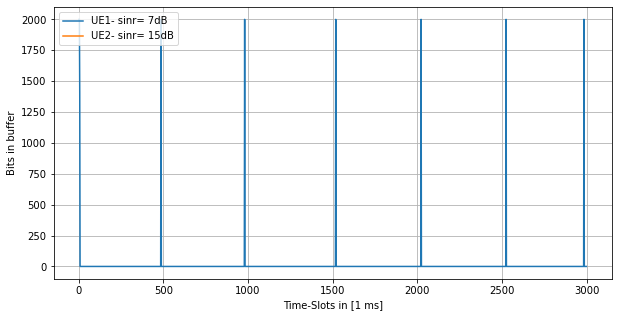

In [47]:
plt.figure(figsize=(10,5))
plt.plot(ue_list[0].mon.keys(),ue_list[0].mon.values(),label='UE1- sinr= 7dB')
plt.plot(ue_list[6].mon.keys(),ue_list[6].mon.values(),label='UE2- sinr= 15dB')
#plt.plot(ue_list[120].mon.keys(),ue_list[120].mon.values(),label='UE3 -rt')
plt.xlabel('Time-Slots in [1 ms]')
plt.ylabel('Bits in buffer')
plt.legend(loc="upper left")
plt.grid()
#plt.axvline(x = 13, color = 'b', label = 'axvline - full height')
#plt.axvline(x = 27, color = 'b', label = 'axvline - full height')

#Erklärung für high peaks am anfang -> am ANfang werden alle Prozesse gleichzeitig "aktiviert" ->viele Pakete entstehen zur gleichen Zeit